# Unconstrained minimization
*(only the first question)*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

## Gradient and Newton method
$$\text{minimize } f(x)=-\sum_{i=1}^{m}log(1-a_i^Tx)-\sum_{i=1}^nlog(1-x_i^2)$$
Implicit constraints:
1. $\forall i=1,2,\ldots,m, \quad a_i^Tx < 1$
2. $\forall j=1,2,\ldots,n, \quad |x_j| < 1$

Define $y=1-Ax$, $z=1-x^2$ (element-wise):
$$\nabla f(x)=A^T \frac{1}{y} + \frac{2x}{z}$$
$$\nabla^2 f(x)= A^T \text{diag}(\frac{1}{y^2}) A + \text{diag}[\frac{2(1+x^2)}{(1-x^2)^2}]$$

In [2]:
n = 100
m = 200
A = np.random.randn(m, n)

def in_domain(x: np.ndarray):
    y = 1 - A @ x
    z = 1 - np.square(x)
    return np.all(y > 0) and np.all(z > 0)

def f(x: np.ndarray):
    if not in_domain(x):
        return None
    y = 1 - A @ x
    z = 1 - x ** 2
    return -np.log(np.prod(y)) - np.log(np.prod(z))

def grad_f(x: np.ndarray):
    if not in_domain(x):
        return None
    y = 1 - A @ x
    z = 1 - x ** 2
    return A.T @ (1 / y) + x * (2 / z)

def hessian_f(x: np.ndarray):
    if not in_domain(x):
        return None
    y = 1 - A @ x
    lam = 1 / y ** 2
    dg = 2 * (1 + x ** 2) / (1 - x ** 2) ** 2
    return A.T @ np.diag(lam.reshape((m,))) @ A + np.diag(dg.reshape(n,))

### Gradient descent
repeat:
1. $\Delta x=-\nabla f(x)$
2. line search for $t(\alpha, \beta)$
3. $x := x + t\Delta x$  
until $\|\nabla f(x)\|_2 \leq \epsilon$

In [3]:
def gradient_descent(x0: np.ndarray, alpha: float, beta: float, eps: float):
    assert 0 < alpha < 0.5 and 0 < beta < 1
    assert in_domain(x0)
    x = x0
    cnt = 0
    loss = []

    while True:
#         print("step = %d,\t f(x) = %.4f" % (cnt, f(x)))
        loss.append(f(x))
        cnt += 1
        dx = - grad_f(x)
        # line search
        t = 1
        while True:
            x_next = x + t * dx
            if in_domain(x_next) and f(x_next) < f(x) - alpha * t * np.sum(dx ** 2):
                break
            t = beta * t
        x = x + t * dx
        if np.linalg.norm(dx, 2) <= eps:
            break
    return x, np.array(loss)

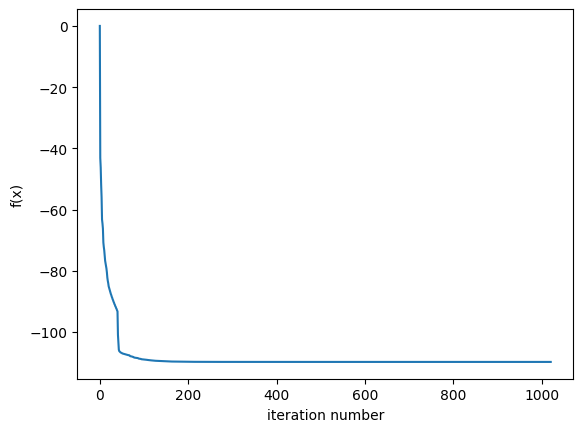

optimal value using gradient: 	 -109.7509


In [8]:
alpha = 0.25
beta = 0.5
eps = 1e-4
x_star, loss = gradient_descent(x0=np.zeros((n, 1)), alpha=alpha, beta=beta, eps=eps)

plt.plot(loss)
plt.ylabel("f(x)")
plt.xlabel("iteration number")
plt.show()
plt.close()
print("optimal value using gradient: \t %.4f" % f(x_star))

### Newton method
repeat:
1. $\Delta x=-\nabla^2 f(x)^{-1} \nabla f(x)$, $\lambda^2 = \nabla f(x)^T \nabla^2 f(x)^{-1} \nabla f(x)$
2. line search for $t(\alpha, \beta)$
3. $x = x + t\Delta x$  
until $\lambda^2 \leq 2\epsilon$

In [9]:
def newton(x0: np.ndarray, alpha: float, beta: float, eps: float):
    cnt, x = 0, x0
    loss = []
    while True:
#         print("f(x) = %.4f" % f(x))
        grad = grad_f(x)
        hessian = np.linalg.inv(hessian_f(x))
        dx = - hessian @ grad
        l2 = grad.T @ hessian @ grad
        loss.append(l2.item())
        if l2 <= 2 * eps:
            break

        t = 1
        while True:
            x_next = x + t * dx
            if in_domain(x_next) and f(x_next) < f(x) - alpha * t * np.sum(dx ** 2):
                break
            t = beta * t
        x = x + t * dx
    return x, loss

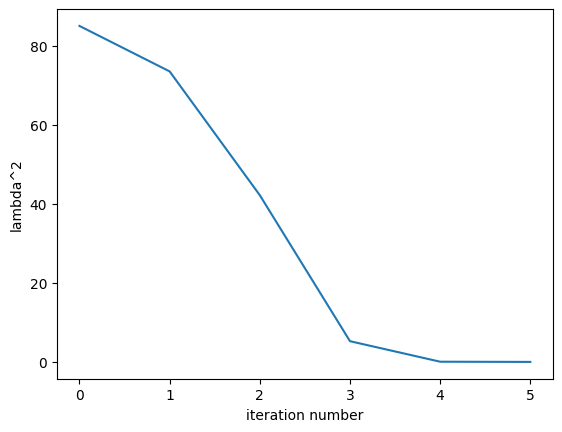

optimal value using newton method: 	 -109.7508


In [10]:
alpha = 0.25
beta = 0.5
eps = 1e-4
x_star, loss = newton(x0=np.zeros((n, 1)), alpha=alpha, beta=beta, eps=eps)

plt.plot(loss)
plt.ylabel("lambda^2")
plt.xlabel("iteration number")
plt.show()
plt.close()
print("optimal value using newton method: \t %.4f" % f(x_star))